In [1]:
%pip install ray

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFE

from sklearn.model_selection import StratifiedKFold

# embedded methods
from sklearn.linear_model import LassoCV
import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder

#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, f1_score

#from utils_train import *
from utils import *
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [16]:
import ray
ray.init()

2024-12-09 22:32:30,922	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-09 22:32:49,702	INFO worker.py:1821 -- Started a local Ray instance.


Python version:,3.12.4
Ray version:,2.40.0


In [17]:
reference_date = pd.to_datetime("2023-01-01")

In [18]:
train_df = pd.read_csv("./data/train_data_after_EDA.csv", index_col="Claim Identifier")

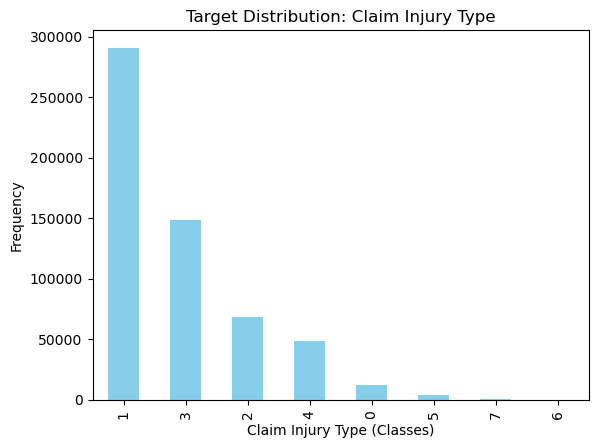

In [19]:
train_df["Claim Injury Type"].value_counts().plot(kind='bar', color='skyblue')
plt.title("Target Distribution: Claim Injury Type")
plt.xlabel("Claim Injury Type (Classes)")
plt.ylabel("Frequency")
plt.show()

In [24]:
numerical_features = [
    "Age at Injury",
    "WCIO Cause of Injury Code",
    "WCIO Nature of Injury Code",
    "WCIO Part Of Body Code",
    "Number of Dependents",
    "Years Past Accident",
    "Assembly Years past Accident",
    "Industry Code",
    "Birth Year",
    "Average Weekly Wage",
    "IME-4 Count"
]

categorical_features = [
    "Carrier Name",
    "Carrier Type",
    "County of Injury",
    "District Name",
    "Gender",
    "Medical Fee Region",
    "Zip Code"
]

binary_features = [
    "Alternative Dispute Resolution",
    "Attorney/Representative",
    "COVID-19 Indicator",
    "First Hearing Date Occurred",
    "C-2 Date Occurred",
    "C-3 Date Occurred"
]


In [26]:
for col in numerical_features+categorical_features+binary_features:
    if col not in train_df.columns:
        print(col)
print("-------")
for col in train_df.columns:
    if col not in numerical_features+categorical_features+binary_features:
        print(col)

-------
Accident Date
Claim Injury Type


# Remove Some NAs

In [29]:
train_df.dropna(subset = ["Accident Date", "Age at Injury","Birth Year","Years Past Accident","Assembly Years past Accident"], inplace=True)

# Data Analises

In [32]:
#train_df["Accident_Days"] = (pd.to_datetime(train_df["Accident Date"]) - reference_date).dt.days

In [34]:
train_df = train_df.drop(columns=["Accident Date"])

In [36]:
train_df.head()

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,...,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Number of Dependents,Years Past Accident,First Hearing Date Occurred,C-2 Date Occurred,C-3 Date Occurred,Assembly Years past Accident
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5393875,31.0,0,0,0.00,1988.0,0.022195,0,1,0.005846,0,...,27.0,10.0,62.0,0.000939,1.0,-3.986311,0,1,0,0.005476
5393091,46.0,0,1,1745.93,1973.0,0.004988,0,3,0.001323,0,...,97.0,49.0,38.0,0.000354,4.0,-4.320329,1,1,1,0.339493
5393889,40.0,0,0,1434.80,1979.0,0.015894,0,3,0.030402,0,...,79.0,7.0,10.0,0.000899,6.0,-4.052019,0,1,0,0.071184
5393887,61.0,0,0,NaN,1958.0,0.193647,1,1,0.020094,0,...,16.0,43.0,36.0,0.003076,1.0,-3.986311,0,1,0,0.005476
5393863,67.0,0,0,0.00,1952.0,0.025027,0,2,0.105272,0,...,31.0,10.0,38.0,0.003226,5.0,-3.997262,0,1,0,0.016427


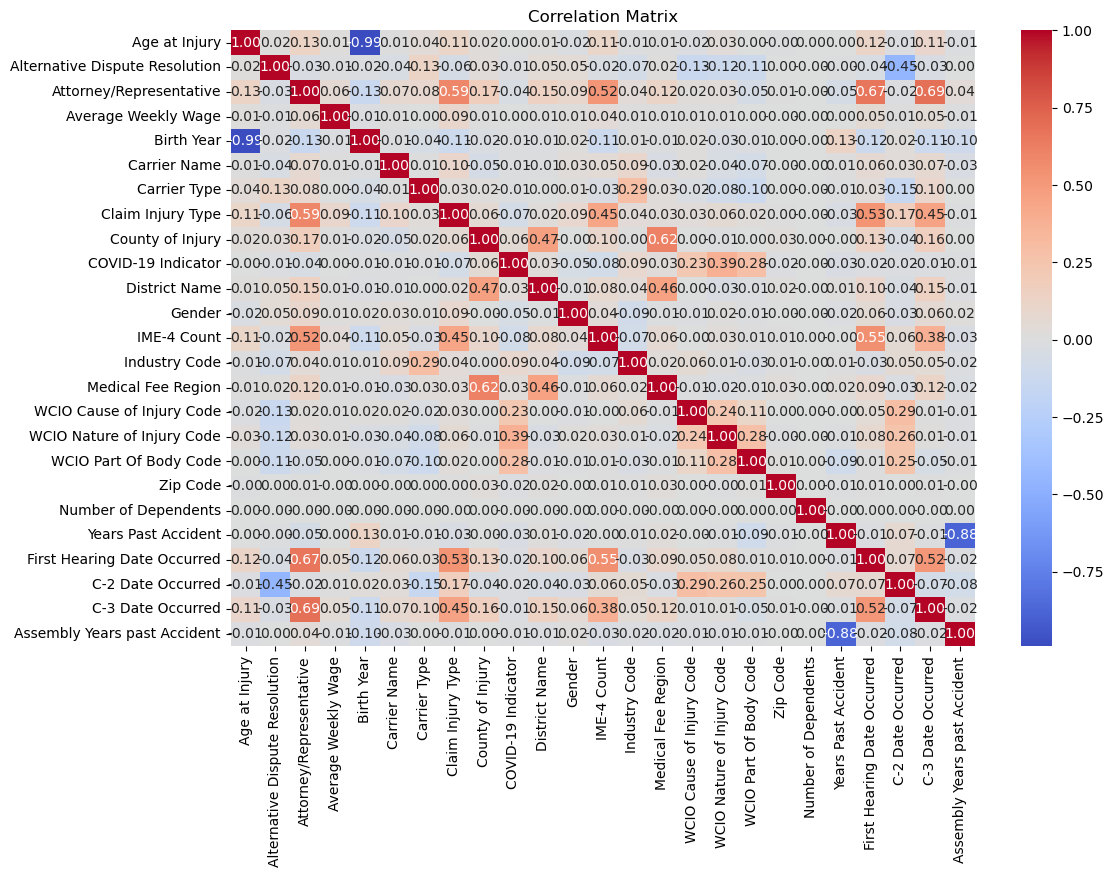

In [38]:
# Compute and visualize correlation matrix
correlation_matrix = train_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

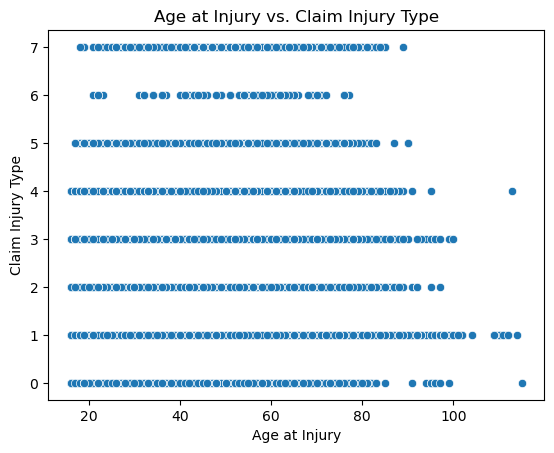

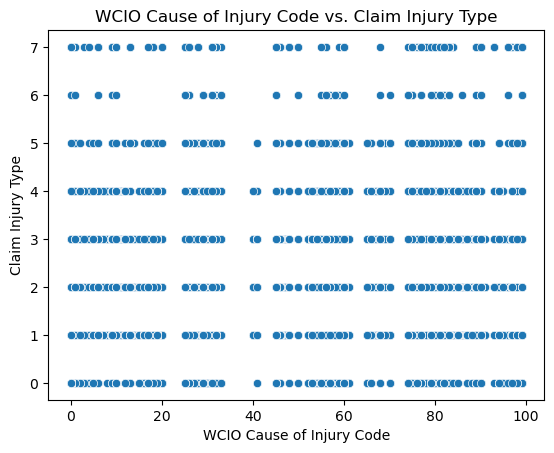

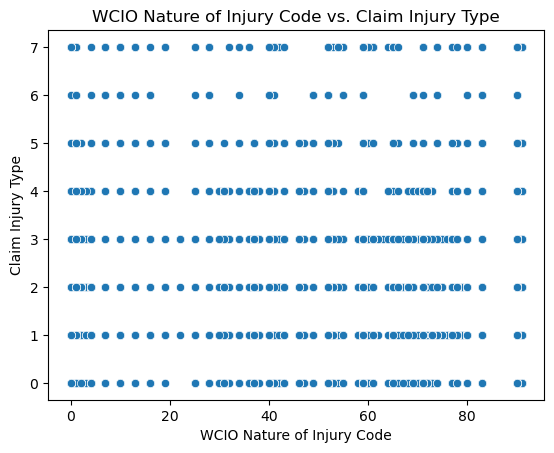

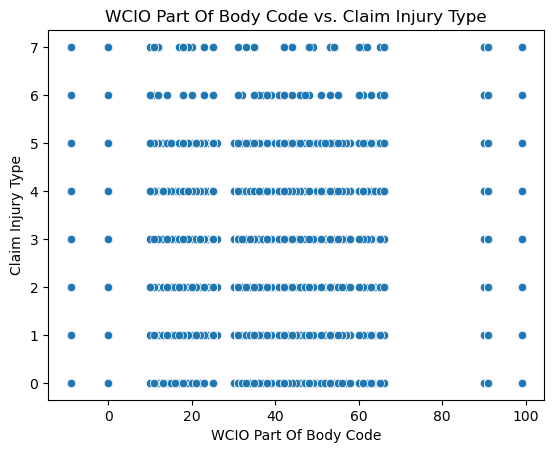

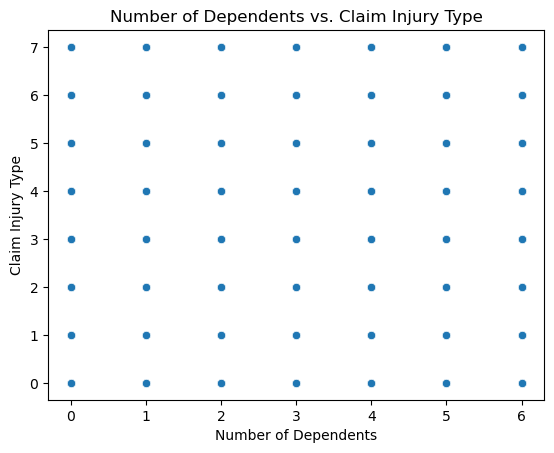

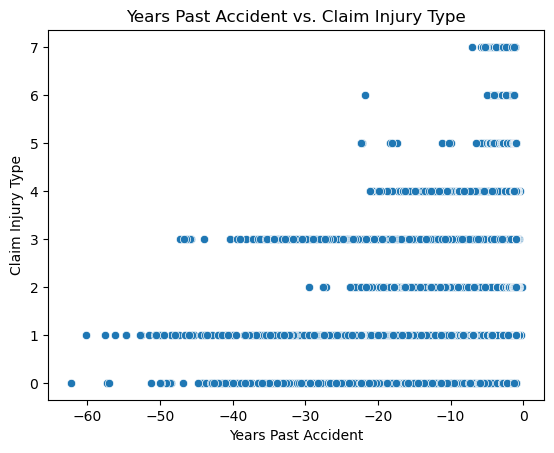

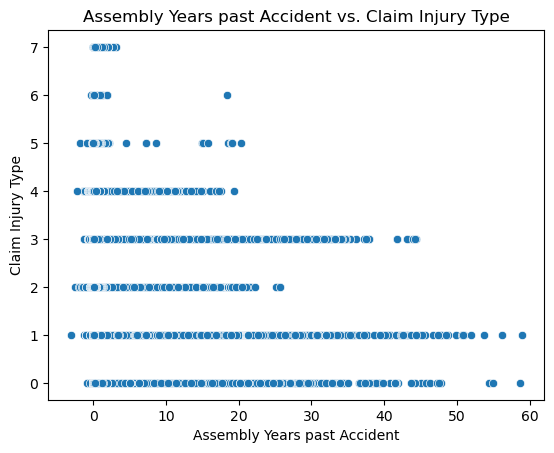

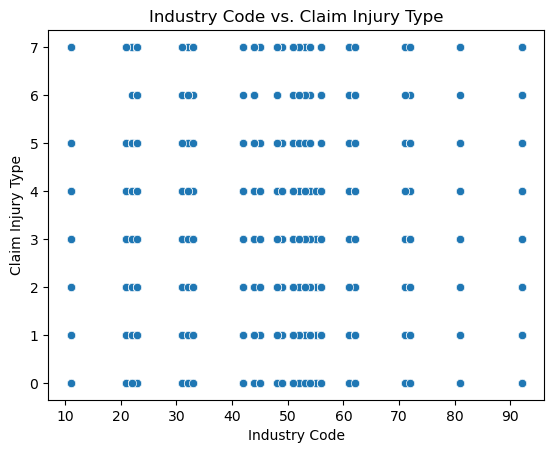

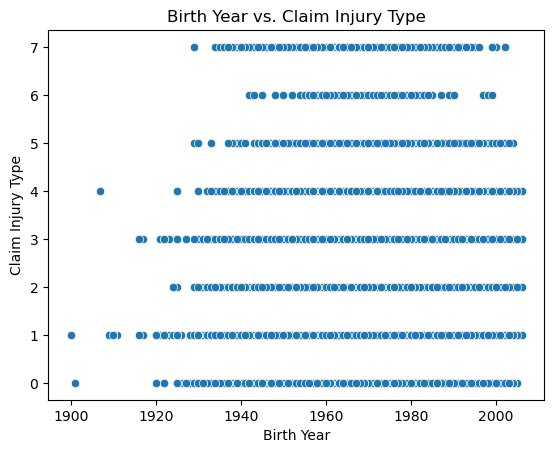

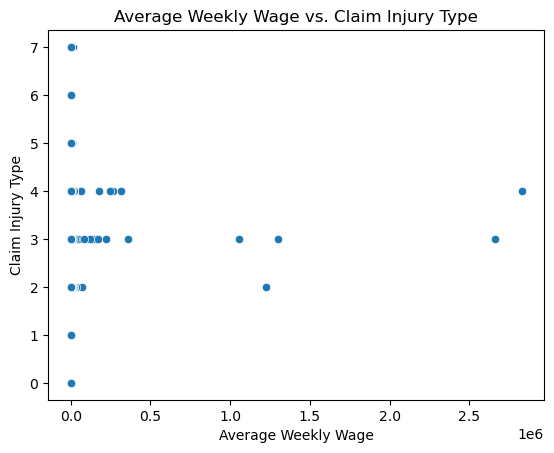

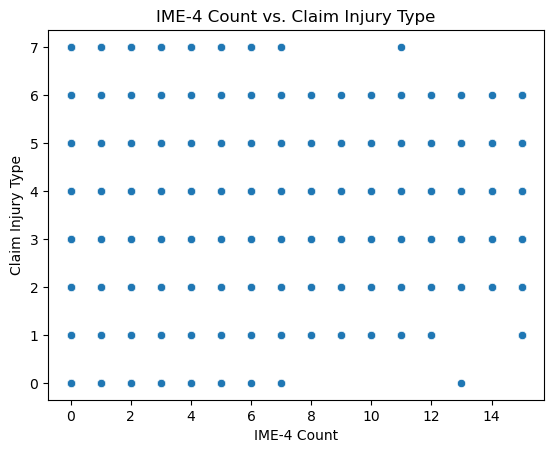

In [40]:
# Example: Scatterplots for numerical features
for feature in numerical_features:
    sns.scatterplot(data=train_df, x=feature, y=train_df["Claim Injury Type"])
    plt.title(f"{feature} vs. Claim Injury Type")
    plt.xlabel(feature)
    plt.ylabel("Claim Injury Type")
    plt.show()

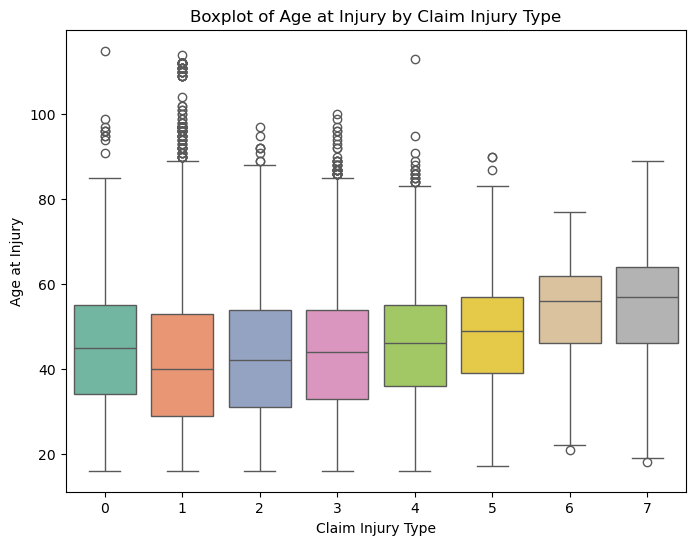

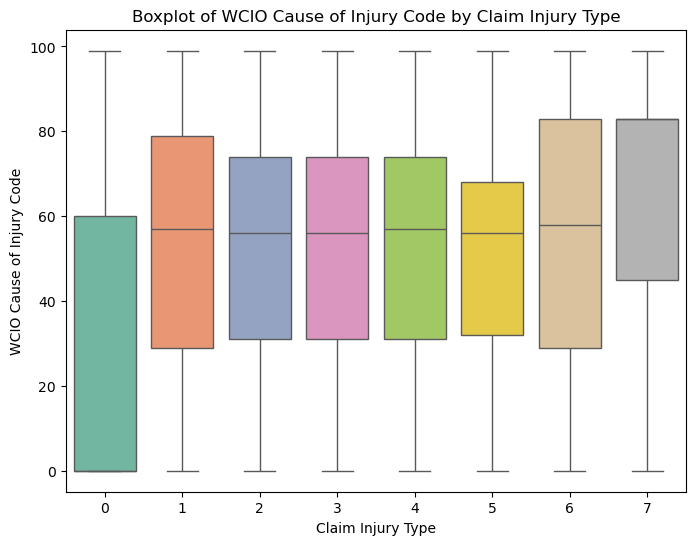

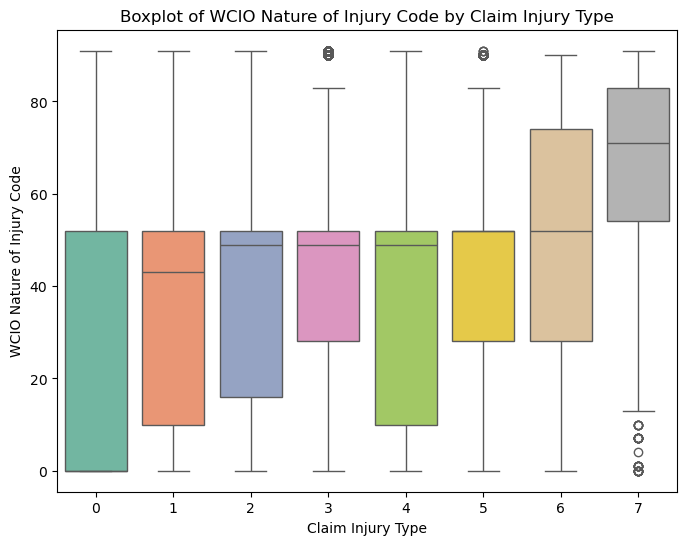

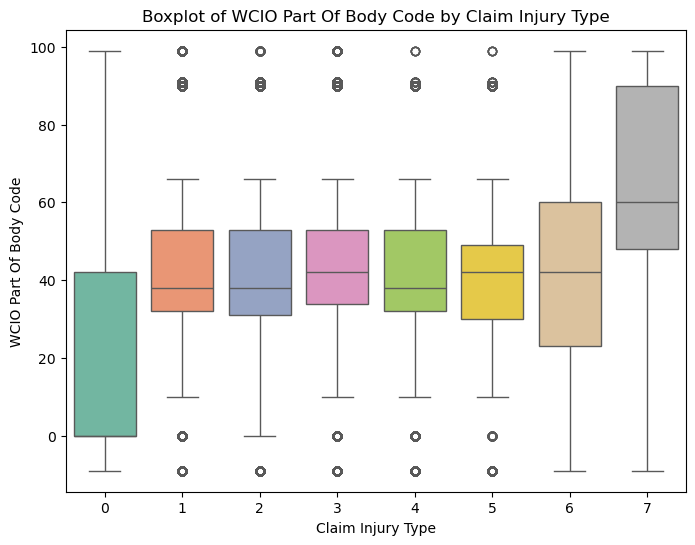

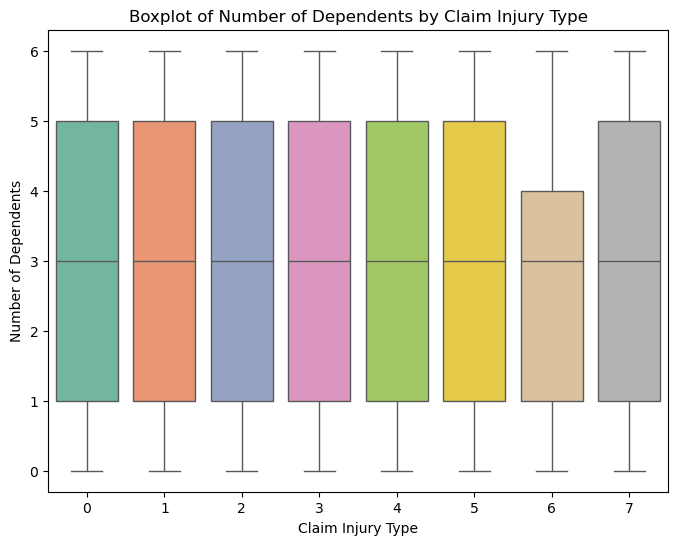

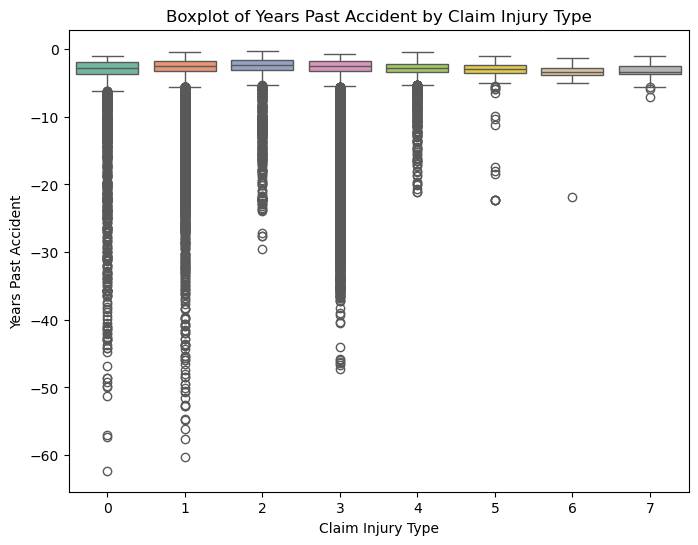

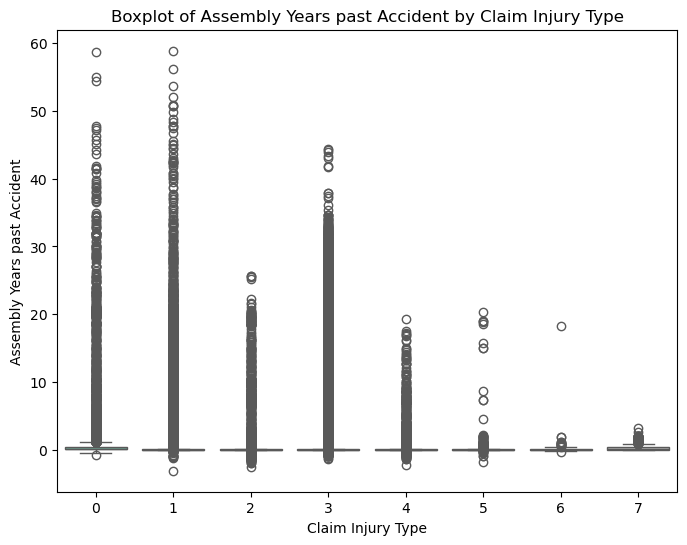

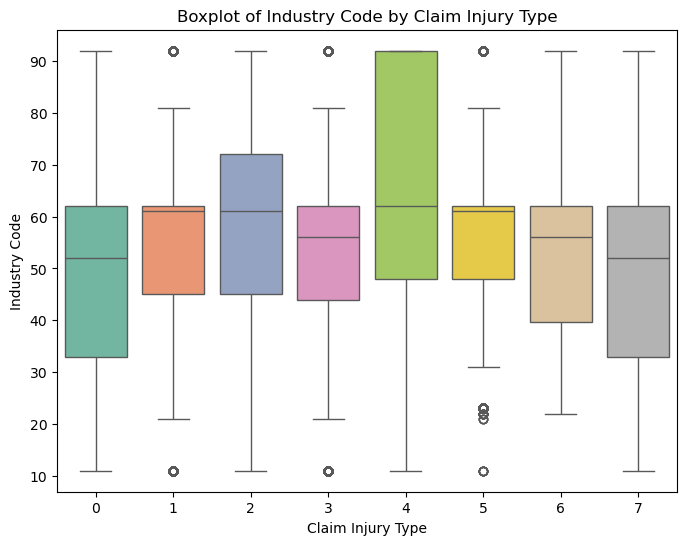

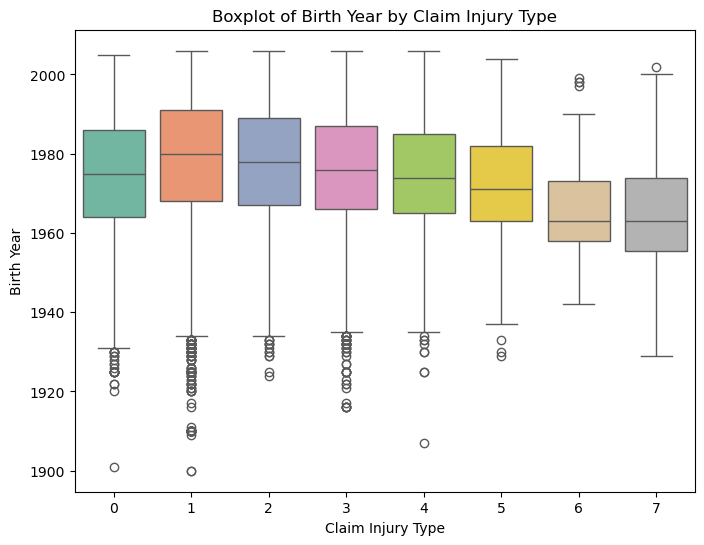

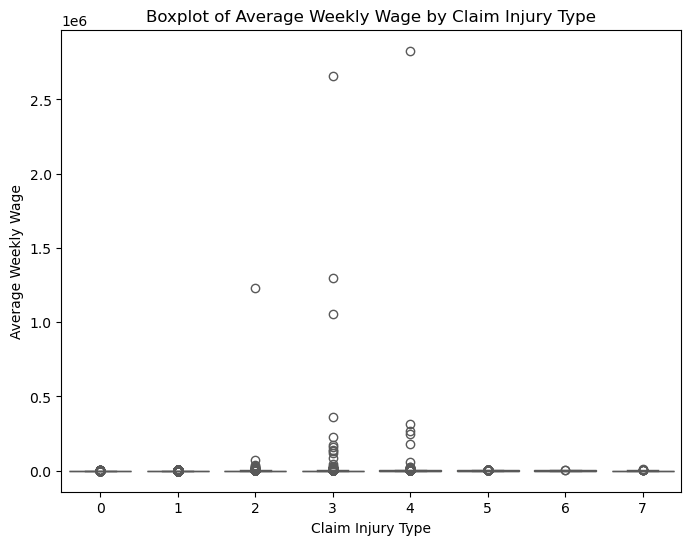

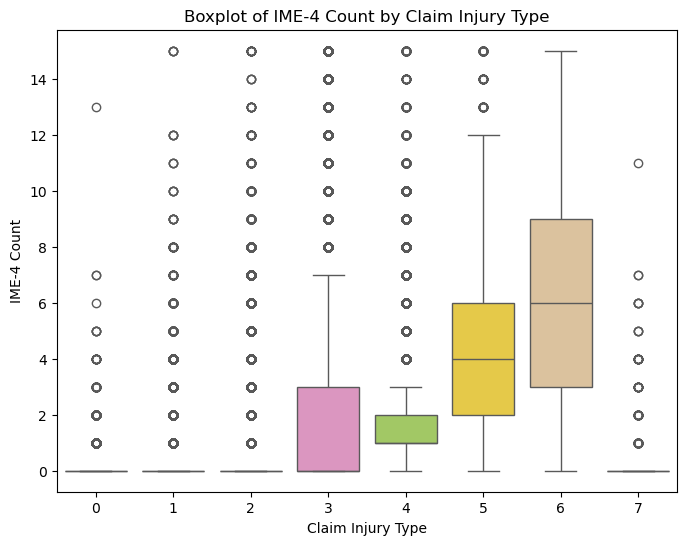

In [42]:
categorical_target = "Claim Injury Type" 

# Generate boxplots for each numerical feature grouped by the target
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=train_df, x=categorical_target, y=feature, palette="Set2")
    plt.title(f"Boxplot of {feature} by {categorical_target}")
    plt.xlabel(categorical_target)
    plt.ylabel(feature)
    plt.show()

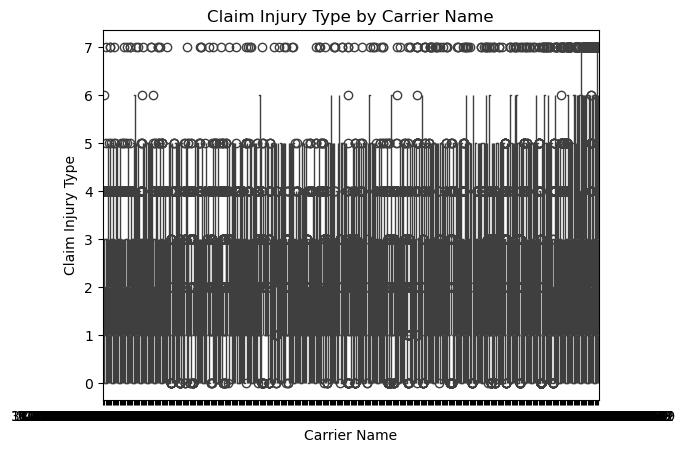

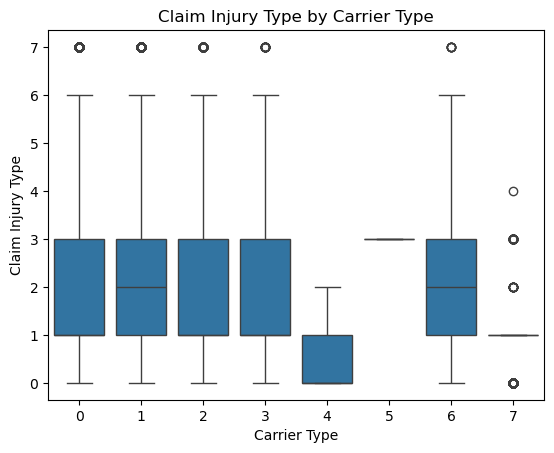

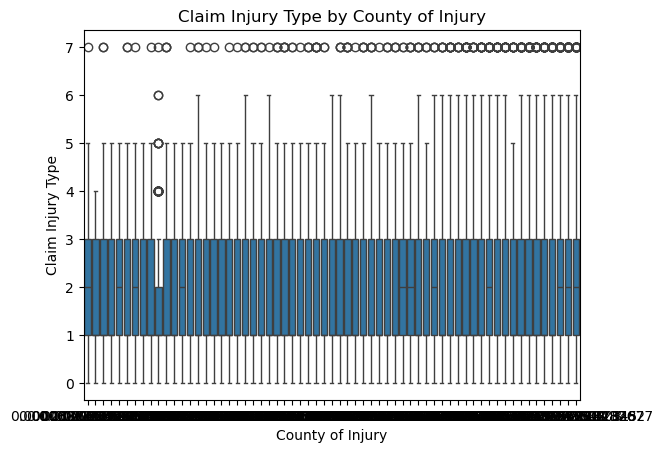

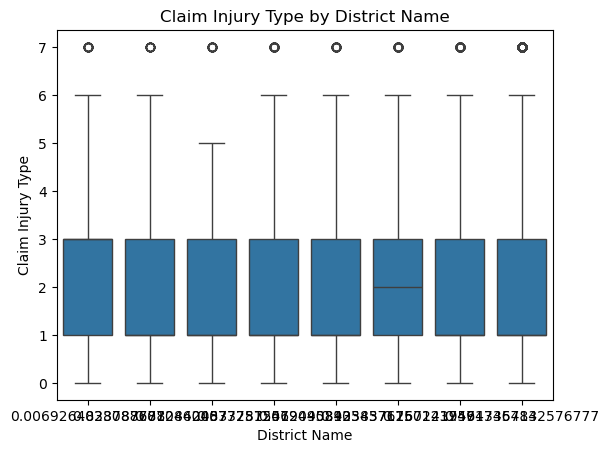

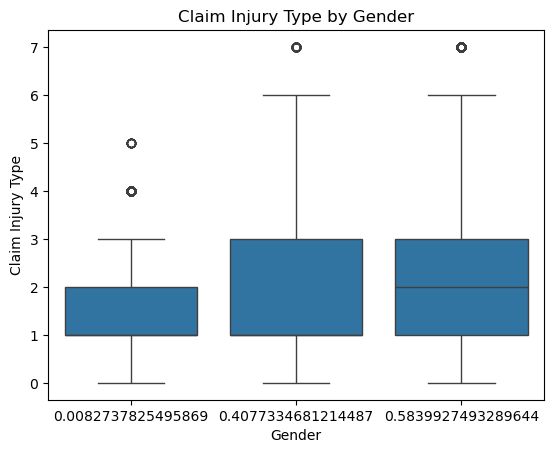

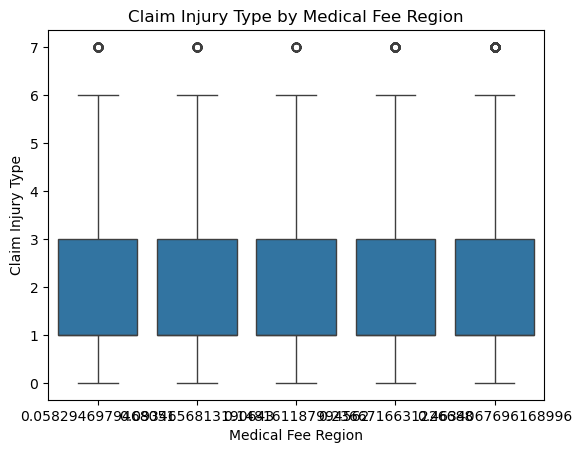

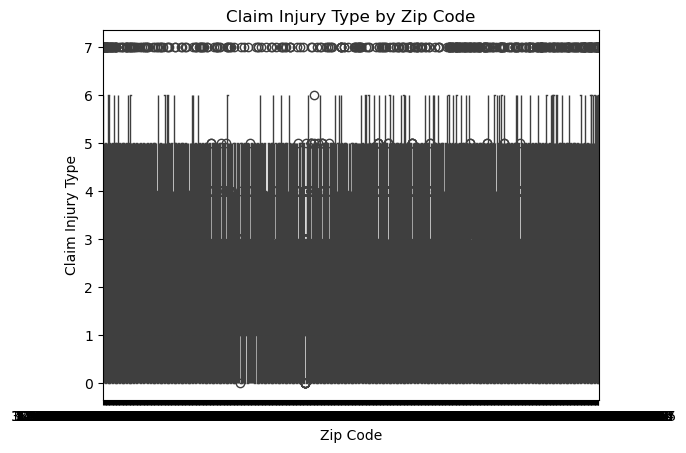

In [43]:
for cat_feature in categorical_features:
    sns.boxplot(data=train_df, x=cat_feature, y=categorical_target)
    plt.title(f"{categorical_target} by {cat_feature}")
    plt.xlabel(cat_feature)
    plt.ylabel(categorical_target)
    plt.show()

1. Data analises - correlation matrix, features plots.
2. draw plots and decide columns to drop and keep and scale
3. Normalize data and improve Classes samples sizes the frequency is completely disparse
4. Run the model again 
5. Interpret data 

In [47]:
X = train_df.drop(["Claim Injury Type"], axis = 1)
y = train_df["Claim Injury Type"]

# 10% data split

In [50]:
 X, X_test, y, y_test = train_test_split(X,y, test_size = 0.1, random_state = None, stratify = y, shuffle = True)

## Train Val Split

In [53]:
 X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.25, random_state = None, stratify = y, shuffle = True)

## Impute NAs

In [56]:
to_impute = ["Average Weekly Wage","Industry Code"]
percent_missing = X_train[to_impute].isnull().mean()
imputation_value = percent_missing / ((1 / 0.97) - 1)
for col in to_impute:
        X_train[col].fillna(imputation_value[col], inplace=True)
        X_val[col].fillna(imputation_value[col], inplace=True)

# Apply Feature Selection

In [59]:
features_to_drop = ["Assembly Years past Accident","Birth Year", "Zip Code", "Number of Dependents", "Medical Fee Region"]

features_to_scale = [
    "Age at Injury",
    "WCIO Cause of Injury Code",
    "WCIO Nature of Injury Code",
    "WCIO Part Of Body Code",
    "Industry Code",
    "Average Weekly Wage",
    "IME-4 Count"
]

In [61]:
scaler = StandardScaler().fit(X_train[features_to_scale])
X_train[features_to_scale] = scaler.transform(X_train[features_to_scale])
X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])

In [63]:
X_train.drop(features_to_drop, axis=1, inplace=True)
X_val.drop(features_to_drop, axis=1, inplace=True)

### ACCESS Oversampling and Undersampling

In [66]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"Class_weight_dict: {class_weight_dict}")

Class_weight_dict: {0: 6.612400027578599, 1: 0.246649615776317, 2: 1.035324502882311, 3: 0.48028529791773084, 4: 1.4721740398489547, 5: 16.873020760028147, 6: 737.7403846153846, 7: 152.23214285714286}


In [68]:
# Assuming `y_train` is your target variable
class_counts = pd.Series(y_train).value_counts()

# Display class distribution
print("Class Distribution:\n", class_counts)

Class Distribution:
 Claim Injury Type
1    194418
3     99843
2     46317
4     32573
0      7252
5      2842
7       315
6        65
Name: count, dtype: int64


In [70]:
total_samples = len(y_train)
class_proportions = class_counts / total_samples * 100

print("Class Proportions (%):\n", class_proportions)

Class Proportions (%):
 Claim Injury Type
1    50.679179
3    26.026197
2    12.073509
4     8.490844
0     1.890388
5     0.740828
7     0.082111
6     0.016944
Name: count, dtype: float64


In [72]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(y_train_balanced.value_counts())

Class distribution after SMOTE:
Claim Injury Type
1    194418
2    194418
0    194418
3    194418
4    194418
5    194418
6    194418
7    194418
Name: count, dtype: int64


In [74]:
# from imblearn.combine import SMOTETomek

# original_counts = y_train.value_counts()
# sampling_strategy = {
#    cls: max(original_counts[cls], int(class_weight_dict[cls] * len(y_train)))
#    for cls in class_weight_dict
# }

# smote_tomek = SMOTETomek(sampling_strategy="auto", random_state=42)
# X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

#print("Class Distribution After SMOTETomek:\n", pd.Series(y_train_balanced).value_counts())

#from imblearn.over_sampling import ADASYN

# Define the ADASYN oversampler
#adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)

# Fit and resample the training data
#X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Display the new class distribution
#print("Class Distribution After ADASYN:\n", pd.Series(y_train_resampled).value_counts())

In [76]:
def XGB_GridSearch_prev(config):

    X_train = ray.get(X_train_ref)
    y_train = ray.get(y_train_ref)
    
    # Create and fit the model
    model = xgb.XGBClassifier(
        max_depth=config["max_depth"],
        learning_rate=config["learning_rate"],
        n_estimators=config["n_estimators"]
    )

    sample_weights = np.array([config["class_weight_dict"][label] for label in y_train])
    # Train the model on the training dataset
    model.fit(X_train, y_train)
    
    # Validation Predictions and F1 Score
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average="macro")

    # Report Results to Ray
    session.report({"f1_score": f1})

In [78]:
def XGB_GridSearch(config):

    X_train = ray.get(X_train_ref)
    y_train = ray.get(y_train_ref)
    
    # Create and fit the model
    model = xgb.XGBClassifier(
        max_depth=config["max_depth"],
        learning_rate=config["learning_rate"],
        n_estimators=config["n_estimators"],
        gamma=config["gamma"]
    )
    
    model.fit(X_train, y_train)
    
    # Validation Predictions and F1 Score
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average="macro")

    # Report Results to Ray
    session.report({"f1_score": f1})

In [80]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session

2024-12-09 22:39:22,055	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [ ]:
#X_train_ref = ray.put(X_train_balanced)
#y_train_ref = ray.put(y_train_balanced)

X_train_ref = ray.put(X_train_balanced)
y_train_ref = ray.put(y_train_balanced)

# Define the hyperparameter search space
search_space = {
    "max_depth": tune.grid_search([3, 9, 11]),  # Allow deeper trees
    "learning_rate": tune.grid_search([0.01, 0.2, 0.5]),  # Smaller steps
    "n_estimators": tune.grid_search([200, 500, 1000]),  # More estimators
    "gamma": tune.grid_search([0, 0.1, 1.0]),  # Minimum split improvement
}

# Execute the grid search
analysis = tune.run(
    XGB_GridSearch,
    config=search_space,
    resources_per_trial={"cpu": 1},  # Allocate 1 CPU per trial
    scheduler=ASHAScheduler(metric="f1_score", mode="max"),  # Manage trials efficiently
    verbose=1
)

(raylet) Warning: The actor ImplicitFunc is very large (44 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


2024-12-10 02:08:16,302	WARNING util.py:201 -- The `on_step_begin` operation took 2.159 s, which may be a performance bottleneck.
2024-12-10 15:32:40,760	WARNING util.py:201 -- The `on_step_begin` operation took 3.701 s, which may be a performance bottleneck.
2024-12-10 19:09:01,785	WARNING util.py:201 -- The `on_step_begin` operation took 1.670 s, which may be a performance bottleneck.
2024-12-10 20:27:37,144	WARNING util.py:201 -- The `on_step_begin` operation took 0.589 s, which may be a performance bottleneck.


In [ ]:
# Retrieve the best configuration
best_config = analysis.get_best_config(metric="f1_score", mode="max")
print(f"Best hyperparameters: {best_config}")

In [262]:
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
X_test.drop(features_to_drop, axis=1, inplace=True)

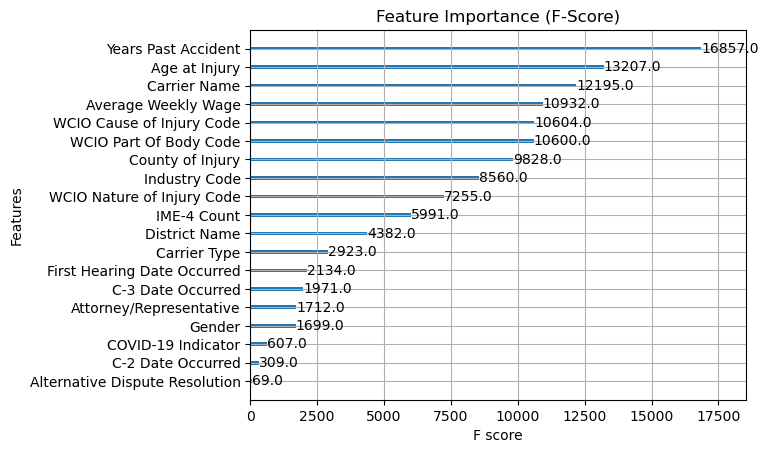

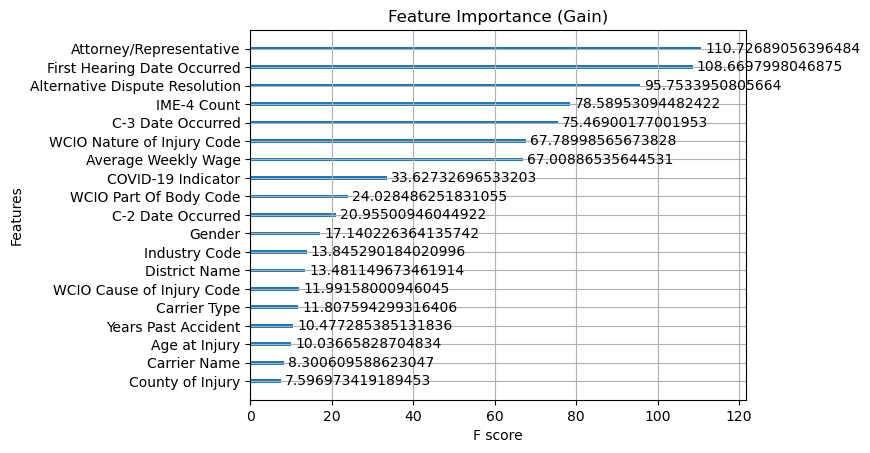

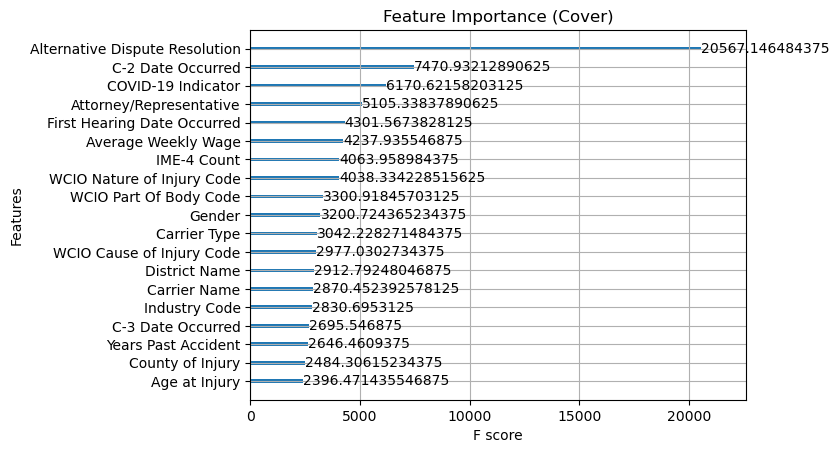

In [264]:
# Instantiate the model with the best configuration
model = xgb.XGBClassifier(**best_config)
sample_weights = np.array([class_weight_dict[label] for label in y_train])
# Train the model on the training dataset
model.fit(X_train, y_train, sample_weight=sample_weights)

from xgboost import plot_importance

# Plot F-Score (weight-based importance)
plot_importance(model, importance_type="weight", max_num_features=20)
plt.title("Feature Importance (F-Score)")
plt.show()

# Plot Gain-based importance
plot_importance(model, importance_type="gain", max_num_features=20)
plt.title("Feature Importance (Gain)")
plt.show()

# Plot Cover-based importance
plot_importance(model, importance_type="cover", max_num_features=20)
plt.title("Feature Importance (Cover)")
plt.show()

# Predict on the test set
y_pred = model.predict(X_test)

In [265]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.67      0.41      1074
           1       0.90      0.79      0.84     28803
           2       0.33      0.33      0.33      6862
           3       0.73      0.65      0.68     14791
           4       0.55      0.80      0.65      4826
           5       0.10      0.48      0.16       421
           6       0.00      0.00      0.00        10
           7       0.40      0.51      0.45        47

    accuracy                           0.69     56834
   macro avg       0.41      0.53      0.44     56834
weighted avg       0.74      0.69      0.71     56834



Soluções testadas: 
1. Melhorar features usadas.
    1.1. Foram desenhados gráficos, uma matrix de correlação e 3 gráficos de feature importance (
       1.1.1.	Weight (default):
	•	Measures the number of times a feature is used to split data across all trees.
	•	Good for identifying frequently used features.
       1.1.2	Gain:
	•	Measures the average improvement in accuracy brought by a feature across all splits it’s involved in.
	•	Useful for identifying features with the most predictive power.
       1.1.3.	Cover:
	•	Measures the relative coverage of a feature, i.e., the number of samples affected by splits involving the feature.)
2. Devido a um model de dados muito desiquilbrado, como é possivel observaar no histograma de classes, tentamos algoritmos de oversampling e undersampling, nomeadament: SMOTE, SMOTEENN SMOTETomek e ADASYN. Resultados muito parecidos em todos
3. Usamos mecanismos de sample_weight para atribuir diferentes pesos a cada instancia da class. Ainda tentamos scale_pos_weight, melhorava o model para 78% de accuracy, mas seria parecido ao modelo xgboost mais simples do passo 3, em que classes minoritarias tinham scores super baixos.
4. Por fim ajustamos o ray tune para termos um ritmo de aprendizagem mais lento e com mais estimators, ainda a correr.